#### Change log
- 3/7/2020 - Added multiple new graph & centrality metrics

# Section 1 - Setup, data import, and function definitions.

In [1]:
import networkx as nx
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter
import warnings
import os
import time
#import nxviz as nv
from scipy import stats
from datetime import datetime

warnings.filterwarnings('ignore')  # suppress warning messages
%matplotlib inline
sns.set()

In [2]:
# Import artist_dictionary.data, tags_dict.data, and yahoo ratings.csv
# from working directory.

artist_dictionary = pickle.load(open('artist_dictionary.data','rb'))   
tags_dictionary = pickle.load(open('tags_dict.data','rb'))
ratings = pd.read_csv('artist-yahoo-ratings.csv') 

In [3]:
# Import the super graph from working directory.
"""
super_graph = pickle.load(open('super_graph.data','rb'))

print(type(super_graph))
print(len(super_graph.nodes()), 'nodes')
print(len(artist_dictionary.keys()), 'keys in artist dictionary')
print(len(super_graph.edges()), 'edges')  """ 

"\nsuper_graph = pickle.load(open('super_graph.data','rb'))\n\nprint(type(super_graph))\nprint(len(super_graph.nodes()), 'nodes')\nprint(len(artist_dictionary.keys()), 'keys in artist dictionary')\nprint(len(super_graph.edges()), 'edges')  "

In [4]:
def get_edges(dictionary,label):
    """Create a list of edges from a dictionary.
        
    Create a list of labeled edges for a network graph by comparing the values (artists)
    of each key (band) in a dictionary.  If two values share a key, return a list of
    (key,key,{link:shared value}) tuples.
        
    Parameters
    ----------
    dictionary : dict
    
    label : str
            Label to be used as key in edge metadata, used to describe node relationship.
        
    Returns
    -------
    edgelist : list of str and dict
        
    """
    edgelist = []
    for  key, value in dictionary.items():
        for items in value:
            for key1, value1 in dictionary.items():
                for items1 in value1:
                    if len(items) > 1 and len(items1) > 1: # Prevent single letter artists 
                                                         # ('G' or 'K') from linking with
                        if items in items1:              # every artist with a g or k in their name.
                            edgelist.append((key,key1,{label:items})) 
                           
    return edgelist

In [5]:
def build_net(seed, goal=None, size=600, graph=True):
    """ Build an artist-based network graph.
    
    Create an undirected, artist-based network graph with labeled edges. Basic
    graph structure is equivelant to (band1) <-- shared artist --> (band2). By 
    default, function will build networks of size 600 (node count / bands.)
    Optionally, the function can also produce a network that starts with a 
    band (seed) and builds a network until it contains the a second band (goal.)  
    Warning! There is no check for whether two bands reside in the same network.  It is
    possible to specify a seed and goal for which a relationship does not exist.
    
    Parameters
    ----------
    seed : str
           Seed band around wihch a network graph is built.  Also root of tree search.   
    
    goal : str
            The function will stop growing the network graph once it contains the goal (band).
            Optional, default = None.
    
    size : int
           Size of the network graph, defined by node count.
           Optional, default = 600 nodes (bands.)
            
    graph : bool
            True = return graph object, False = return node/edge lists.

    Returns
    -------
    graph : networkX graph object
            if graph=True, return undirected graph 
           
    nodes,edges : list of str
                  if graph=False, return node and edge lists
    
    """
    artist_list = []
    band_list = []
 
    artistindex = 0  # Use index markers to keep track of progress and
    bandindex = 0    # avoid iterating over the entire artist and band lists.
       
    band_list.append(seed)  # Level 1 seed band (root). 
    
    if goal is not None:
        
        if nx.has_path(seed,goal) == True:  # Check that a path between seed and goal exists.
            
            while goal not in band_list:
                for band in band_list[bandindex:]:               # Only retrieve artists for 'new' bands 
                    for artist in artist_dictionary[band]:       # in band_list. 
                        if artist not in artist_list:
                            artist_list.append(artist)           # Add new artists to artist_list.                         
            
                bandindex = len(band_list)                       # Mark current bands in band_list as 'worked' 
                                                                 # by setting index marker to the first index 
                                                                 # following last element in band_list.
            
                for artist in artist_list[artistindex:]:         # Only retrieve bands for 'new' artists
                    for key, value in artist_dictionary.items(): # in artist_list.
                        if artist in value:
                            if key not in band_list:
                                if goal not in band_list:
                                    band_list.append(key)        # Add new bands to band_list.
            
                artistindex = len(artist_list)                   # Mark current artists in artist_list as 'worked'
                                                                 # by setting index marker to the first index 
        else:                                                    # following the last element in artist_list. 
            
            print('A path between ',seed,' and ',goal,' does not exist.')                          
    
    else:
        while len(band_list) <= size:         
            for band in band_list[bandindex:]:
                for artist in artist_dictionary[band]:
                    if artist not in artist_list:
                        artist_list.append(artist)                                 
            
            bandindex = len(band_list)
            
            for artist in artist_list[artistindex:]:
                for key, value in artist_dictionary.items():
                    if artist in value:
                        if key not in band_list:
                            if len(band_list) <= size:
                                band_list.append(key)
    
            artistindex = len(artist_list)
            
    dictionary = {band : artist_dictionary[band] for band in band_list}  # local artist dictionary 
    
    for key, value in dictionary.items():
        dictionary[key] = set(value)   # filter duplicate group members.
        
    nodes = list(dictionary.keys())
    edges = get_edges(dictionary, 'Artist')
    
    for i in edges:              # remove single edge loops from edge list 
            if i[0] == i[1]:     # ex. ('The Who','The Who',{'artist':'Roger Daltrey'})
                edges.remove(i) 
                
    if graph == False:     
         
        return(nodes, edges) 
        
    else:
        net_graph = nx.MultiGraph()
        net_graph.add_nodes_from(nodes)
        net_graph.add_edges_from(edges)
        
        return(net_graph)

In [6]:
def add_tag_edges(graph, just_edges=False):
    """Add user tag-based edges to an existing artist network graph.
    
    Append user tag-based edges to an existing artist graph and return a   
    multigraph. Creates edges in the form of (band1,band2,{link:tag}) 
    tuple.  This function will not add new nodes to the graph.
    
    Parameters
    ----------
    graph : graph object
            Network graph from which tags will be retrieved, and tag-edges will be added
    
    just_edges : bool
                 If just_edges = True, return new, undirected multigraph object.
                 If just_edges = False, return list of tag-based edges.
                 
    Returns
    -------
    new_graph : networkX multigraph object
    
    tag_edges : list of str
    
    """
    
    new_graph = nx.MultiGraph()
    
    new_graph.add_nodes_from(graph.nodes()) # add nodes from original graph
    
    new_graph.add_edges_from(graph.edges()) # add edges from original graph
       
    bands = [node for node in new_graph.nodes()]             

    dictionary = {band : tags_dictionary[band] for band in bands 
                  if band in tags_dictionary.keys()}  # Check if band exists as a key in
                                                      # in tags_dictionary.                       
    tag_edges = get_edges(dictionary,'User-Tag')
        
    for i in tag_edges:          # remove single edge loops from edge list 
        if i[0] == i[1]:         # ex. ('The Who','The Who',{'LINK':'classic rock'})
            tag_edges.remove(i) 
                    
    if just_edges == True:
        
        return tag_edges
            
    else:
        new_graph.add_edges_from(tag_edges) 
            
        return new_graph

In [7]:
def centrality(graph):
    """ Compute centrality scores for a network graph.
    
    Compute degree, betweeness, and load centrality measures, the mean of 
    all three centrality measures, page rank and HITS scores for all nodes 
    in a network graph. 
    
    Parameters
    ----------
    graph : networkX graph object
    
    Returns
    -------
    core_df : Pandas DataFrame object
    
    """
    
    core_df = pd.DataFrame()
    core_df['artist'] = graph.nodes() # Add to the artist column all nodes (artists) in a graph.
     
    deg_cent = nx.degree_centrality(graph)
    degdf = pd.DataFrame.from_dict(deg_cent, 
                                   orient ='index',
                                   columns = ['deg_cent'])

    #between_cent = nx.betweenness_centrality(graph)
    #betwdf = pd.DataFrame.from_dict(between_cent,
    #                                orient ='index',
    #                                columns = ['between_cent'])

    load_cent = nx.load_centrality(graph)
    loaddf = pd.DataFrame.from_dict(load_cent,
                                    orient ='index',
                                    columns = ['load_cent'])

    core_df = core_df.merge(degdf,
                            left_on = 'artist',
                            right_index = True)

    #core_df = core_df.merge(betwdf,
    #                        left_on = 'artist',
    #                        right_index = True)

    core_df = core_df.merge(loaddf,
                            left_on = 'artist',
                            right_index = True)
    
    core_df['mean_cent'] = core_df.apply(lambda row: np.mean(row[1:]),   #  Calculate the mean of the centrality scores.
                                    axis = 1)
    
    page_rank = nx.pagerank_numpy(graph)
    page_rank_df = pd.DataFrame.from_dict(page_rank,
                                          orient = 'index',
                                         columns = ['page_rank'])
    
    hubs, authorities = nx.hits_numpy(graph)     # experimenting for now, hub and authority values are equal 
    hub_df = pd.DataFrame.from_dict(hubs,        # in an undirected graph.  Graphs may eventually have directed edges?
                                    orient = 'index',
                                    columns = ['HITS_hub'])
    
    auth_df = pd.DataFrame.from_dict(authorities,
                                    orient = 'index',
                                    columns =['HITS_auth'])
    
    core_df = core_df.merge(page_rank_df,
                            how = 'left',
                            left_on = 'artist',
                            right_index = True)
        
    core_df = core_df.merge(hub_df,
                            how = 'left',
                            left_on = 'artist',
                            right_index = True) 
        
    core_df = core_df.merge(auth_df,
                            how = 'left',
                            left_on = 'artist',
                            right_index = True) 
    return core_df

In [8]:
"""

# Create a super graph of all artists in artist_dictionary 
# in order to check if two music groups are connected.  The 
# graph will be used in graphing functions later on in 
# the project.

super_net_edges = get_edges(artist_dictionary)         

super_net = nx.MultiGraph() 

super_net.add_edges_from(super_net_edges)  

file = open('super_graph.data','wb')  #  Pickle and write super_graph to disk.
pickle.dump(super_net,file)
file.close()

"""

"\n\n# Create a super graph of all artists in artist_dictionary \n# in order to check if two music groups are connected.  The \n# graph will be used in graphing functions later on in \n# the project.\n\nsuper_net_edges = get_edges(artist_dictionary)         \n\nsuper_net = nx.MultiGraph() \n\nsuper_net.add_edges_from(super_net_edges)  \n\nfile = open('super_graph.data','wb')  #  Pickle and write super_graph to disk.\npickle.dump(super_net,file)\nfile.close()\n\n"

# Section 2  - Generating and exploring an artist-based graph.

In [9]:
band = 'The Rolling Stones' # Build a network graph for this musical group. 

In [10]:
artist_dictionary[band]

['Billy Preston',
 'Charlie Watts',
 'Lisa Fischer',
 'Lisa Fischer',
 'Mick Jagger',
 'Brian Jones',
 'Keith Richards',
 'Bill Wyman',
 'Mick Taylor',
 'Bernard Fowler',
 'Chuck Leavell',
 'Ron Wood',
 'Mick Avory',
 'Ian Stewart',
 'Tony Chapman',
 'Dick Taylor',
 'Bobby Keys',
 'Bobby Keys',
 'Darryl Jones',
 'Blondie Chaplin',
 'Blondie Chaplin']

In [11]:
tags_dictionary[band]

['country',
 'reggae',
 'blues',
 'rock and roll',
 'rnb',
 'english',
 'uk',
 'rhythm & blues',
 'classic pop and rock',
 'live',
 'pop rock',
 'the-rolling-stones',
 'greatest hits',
 'rock & roll',
 'psychedelic rock',
 'some girls',
 'classic rock',
 'british',
 'blues rock',
 'rock',
 'britannique',
 'essentials',
 'british rhythm & blues']

In [12]:
graph = build_net(band)  # Create a network graph object for 'band'.

# g1 = nx.draw(graph, with_labels = False)  # draw the graph 

print(len(graph.nodes()),' nodes')
print(len(graph.edges()),' edges')

601  nodes
9189  edges


In [13]:
# DataFrame of centrality/page rank measures for the artist graph
graph_df = centrality(graph)

graph_df = graph_df.sort_values(by = ['page_rank'],
                              ascending = False)
graph_df.head(n=20)

,artist,deg_cent,load_cent,mean_cent,page_rank,HITS_hub,HITS_auth
15,Artists United Against Apartheid,0.736667,0.380365,0.558516,0.024839,0.033005,0.033005
19,John Mayall & The Bluesbreakers,0.353333,0.127374,0.240354,0.010373,0.002405,0.002405
1,The Louisiana Gator Boys,0.253333,0.119293,0.186313,0.010332,0.003729,0.003729
26,The Allman Brothers Band,0.186667,0.069343,0.128005,0.008997,0.000253,0.000253
131,Spirit of the Forest,0.270000,0.051801,0.160900,0.007005,0.019545,0.019545
0,The Rolling Stones,0.180000,0.303758,0.241879,0.006856,0.002844,0.002844
30,Jeff Beck Group,0.163333,0.061937,0.112635,0.005661,0.001407,0.001407
102,Ringo Starr & His All Starr Band,0.220000,0.034683,0.127342,0.005529,0.008016,0.008016
8,Elements of Life,0.170000,0.105473,0.137737,0.005284,0.000291,0.000291
2,Rock Therapy,0.163333,0.042000,0.102667,0.005175,0.001954,0.001954


In [14]:
# Add tag-based edges to the existing artist network graph

tagged_graph = add_tag_edges(graph)

# g2 = nx.draw(tagged_graph, with_labels = False)

print(len(tagged_graph.nodes()),' nodes')
print(len(tagged_graph.edges()),' edges')

601  nodes
74952  edges


In [15]:
# DataFrame of centrality/page rank measures for artist/tag multigraph.

tagged_df = centrality(tagged_graph)
tagged_df = tagged_df.sort_values(by = ['page_rank'],
                            ascending = False)
tagged_df.head(n=20)

,artist,deg_cent,load_cent,mean_cent,page_rank,HITS_hub,HITS_auth
383,The Beatles,6.261667,0.005464,3.133565,0.015659,0.027305,0.027305
0,The Rolling Stones,3.736667,0.061519,1.899093,0.011217,0.016163,0.016163
15,Artists United Against Apartheid,0.736667,0.132860,0.434763,0.009961,0.000474,0.000474
238,Genesis,3.753333,0.012369,1.882851,0.009858,0.016972,0.016972
568,Wings,3.906667,0.002174,1.954420,0.009797,0.017921,0.017921
26,The Allman Brothers Band,2.975000,0.042260,1.508630,0.009637,0.012714,0.012714
433,Fleetwood Mac,3.460000,0.008636,1.734318,0.009173,0.015513,0.015513
109,Queen,3.425000,0.011646,1.718323,0.009025,0.015326,0.015326
578,Black Sabbath,3.440000,0.007118,1.723559,0.009004,0.014864,0.014864
28,Eric Clapton,3.480000,0.003453,1.741726,0.008856,0.015936,0.015936


### Explore the magnitude / effect of self-loops on centrality/pagerank scores.

In [16]:
print(len(list(tagged_graph.nodes_with_selfloops())), ' nodes with self loops')

print(tagged_graph.number_of_selfloops(), ' self loop edges')

330  nodes with self loops
1758  self loop edges


In [17]:
# Drop self loops from the graph

self_loop_list = list(tagged_graph.selfloop_edges())

no_loops = nx.MultiGraph()

no_loops.add_edges_from(list(tagged_graph.edges()))

no_loops.remove_edges_from(self_loop_list)


print(len(list(no_loops.nodes_with_selfloops())), ' nodes with self loops')
print(no_loops.number_of_selfloops(), ' self loop edges')

print(len(no_loops.nodes()),' nodes')
print(len(no_loops.edges()),' edges')

# Check that new edge count is equal to old edge count less self loop edges.

assert (   len(tagged_graph.edges()) 
           - tagged_graph.number_of_selfloops()
           == len(no_loops.edges())  
       )        

0  nodes with self loops
0  self loop edges
601  nodes
73194  edges


In [18]:
len(tagged_graph.nodes())

601

In [19]:
no_self_df = centrality(tagged_graph)
no_self_df = no_self_df.sort_values(by = ['page_rank'],
                            ascending = False)
no_self_df.head(n=20)

,artist,deg_cent,load_cent,mean_cent,page_rank,HITS_hub,HITS_auth
383,The Beatles,6.261667,0.005464,3.133565,0.015659,0.027305,0.027305
0,The Rolling Stones,3.736667,0.061519,1.899093,0.011217,0.016163,0.016163
15,Artists United Against Apartheid,0.736667,0.132860,0.434763,0.009961,0.000474,0.000474
238,Genesis,3.753333,0.012369,1.882851,0.009858,0.016972,0.016972
568,Wings,3.906667,0.002174,1.954420,0.009797,0.017921,0.017921
26,The Allman Brothers Band,2.975000,0.042260,1.508630,0.009637,0.012714,0.012714
433,Fleetwood Mac,3.460000,0.008636,1.734318,0.009173,0.015513,0.015513
109,Queen,3.425000,0.011646,1.718323,0.009025,0.015326,0.015326
578,Black Sabbath,3.440000,0.007118,1.723559,0.009004,0.014864,0.014864
28,Eric Clapton,3.480000,0.003453,1.741726,0.008856,0.015936,0.015936


# Section 3 - Graph analysis.

In [20]:
# Plotting the counts of tags in the network graph

artists = graph_df['artist']

tag_dist = {group:tags_dictionary[group] for group in artists if group in tags_dictionary.keys()}

tag_list = []

for key, value in tag_dist.items():  # Build a list of all tags.
    for tag in value:
        tag_list.append(tag)

print(len(tag_list))

print(len(set(tag_list)))

1583
663


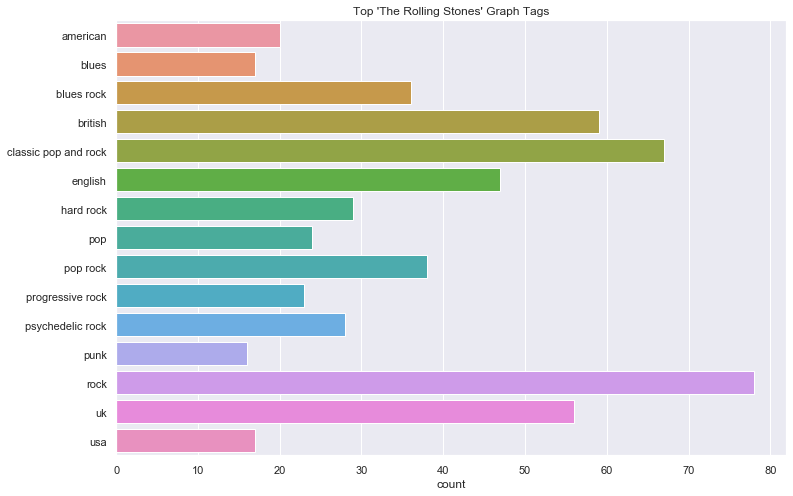

In [24]:
# There are too many tags in the network to plot them all efficiently. 
# Limit plotted tags to those that occur 15 or more times.

new_tag_list = []

tag_count = dict(Counter(tag_list))

short_tag_list = [tag for tag in tag_count if tag_count[tag] >= 15]

for key, value in tag_dist.items():  # build new list of tags that appear 15 or more times
    for tag in value:
        if tag in short_tag_list:
            new_tag_list.append(tag)
            
new_tag_list = sorted(new_tag_list)  # Sorted so tags appear in alphabetical order once plotted.

tag_fig, tag_ax = plt.subplots(figsize = (12,8))

sns.countplot(y = new_tag_list,
              ax = tag_ax)

tag_ax.set(title = 'Top \''+ str(band) + '\' Graph Tags')

plt.show()

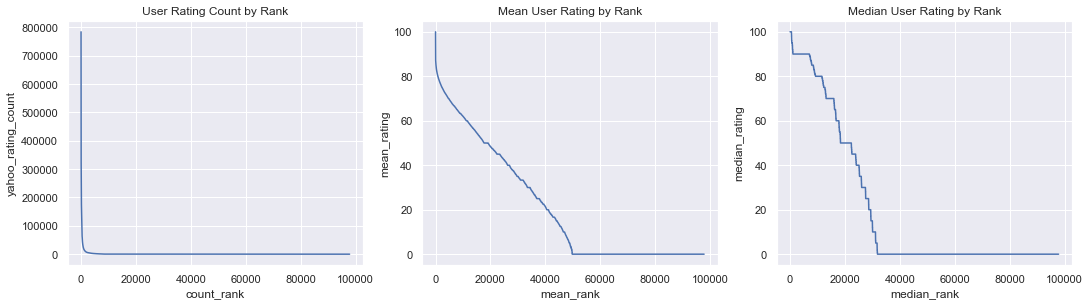

In [25]:
# Plot the distributions of average ratings and rating counts from the Yahoo! data.
# The artists with the highest count or rating are  given the highest rank.

yahoo_fig, axs = plt.subplots(1,3, figsize = (18, 4.5))

sns.lineplot(x = 'count_rank', 
             y = 'yahoo_rating_count', 
             data = ratings, 
             ax = axs[0])

axs[0].set(title = 'User Rating Count by Rank')

sns.lineplot(x = 'mean_rank', 
             y = 'mean_rating', 
             data = ratings, 
             ax = axs[1])

axs[1].set(title = 'Mean User Rating by Rank')

sns.lineplot(x = 'median_rank',
             y = 'median_rating',
             data = ratings,
             ax = axs[2])

axs[2].set(title = 'Median User Rating by Rank')

plt.show()

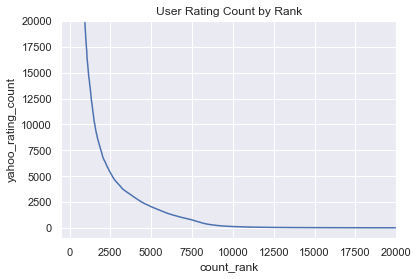

In [26]:
# Zoom in on the count plot

g = sns.lineplot(x = 'count_rank', 
             y = 'yahoo_rating_count', 
             data = ratings)

g.set(title = 'User Rating Count by Rank')

g.set_ylim(bottom = -1000,
           top = 20000)

g.set_xlim(right = 20000,
           left = -500 )
plt.show()

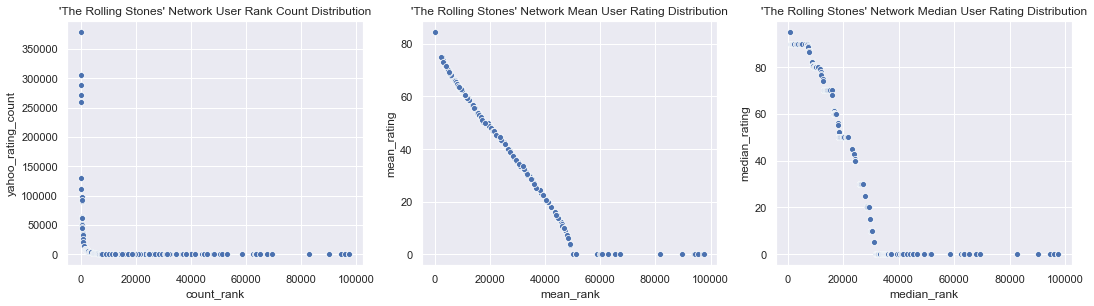

In [27]:
# Plot the distributions of average ratings and rating counts for artists in the 
# Network graph.  The artists with the highest count or rating are given the highest rank.

graphnodes = list(graph.nodes())

network_df = ratings[ratings['artist_name'].isin(graphnodes)] # Create a new DF by selecting those rows that 
                                                              # correspond to nodes in the graph.  
graph_fig, axs = plt.subplots(1,3, figsize = (18, 4.5))

sns.relplot(x = 'count_rank', 
            y = 'yahoo_rating_count', 
            data = network_df,
            ax = axs[0])

axs[0].set(title = '\'' + str(band) + '\' ' + 'Network User Rank Count Distribution')

sns.relplot(x = 'mean_rank', 
            y = 'mean_rating', 
            data = network_df,
            ax = axs[1])

axs[1].set(title = '\'' + str(band) + '\' ' + 'Network Mean User Rating Distribution')

sns.relplot(x = 'median_rank',
            y = 'median_rating',
            data = network_df,
            ax = axs[2])

axs[2].set(title = '\'' + str(band) + '\' ' + 'Network Median User Rating Distribution')

# Maybe improper use of subplots? - multiple empty plots are drawn.  Close for now.
plt.close(2)
plt.close(3)
plt.close(4)

plt.show()

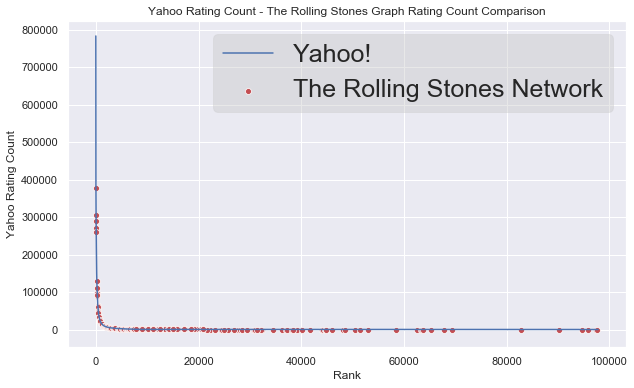

In [28]:
# Plot the network graph artists rating counts against the Yahoo! distribution.

count_fig, cf_ax = plt.subplots(figsize = (10,6))

sns.lineplot(x = 'count_rank', 
             y = 'yahoo_rating_count', 
             data = ratings,
             ax = cf_ax)

sns.relplot(x = 'count_rank', 
            y = 'yahoo_rating_count', 
            data = network_df,
            color = 'r',
            ax = cf_ax)

cf_ax.legend(['Yahoo!',str(band) + ' Network'],
             fontsize = 25,
             facecolor = '0.75',  # grey face color
             framealpha = .35)

cf_ax.set(xlabel = 'Rank',
          ylabel = 'Yahoo Rating Count',
          title =('Yahoo Rating Count - ' + str(band) + ' Graph Rating Count Comparison'))

plt.close(2)

plt.show()

In [ ]:
# Plot the network graph artists mean ratings against the Yahoo! distribution.

layered_fig, lf_ax = plt.subplots(figsize = (10,6))

sns.lineplot(x = 'mean_rank', 
             y = 'mean_rating', 
             data = ratings,
             ax = lf_ax )

sns.relplot(x = 'mean_rank', 
            y = 'mean_rating', 
            data = network_df,
            color = 'r',
            ax = lf_ax)

lf_ax.legend(['Yahoo!',str(band) + ' Network'],
             fontsize = 25,
             facecolor = '0.75',  # grey face color
             framealpha = .35)

lf_ax.set(xlabel = 'Rank',
          ylabel = 'Mean Artist Rating',
          title =('Yahoo Ratings - ' + str(band) + ' Graph Mean Rating Comparison'))

plt.close(2)

plt.show()

In [ ]:
# Plot the network graph artists median ratings of the yahoo distribution."""

layered_fig1, lf1_ax = plt.subplots(figsize = (10,6))

sns.lineplot(x = 'median_rank', 
             y = 'median_rating', 
             data = ratings,
             ax = lf1_ax )

sns.relplot(x = 'median_rank', 
             y = 'median_rating', 
            data = network_df,
            color = 'r',
            ax = lf1_ax)

lf1_ax.legend(['Yahoo!',str(band) + ' Network'],
             fontsize = 25,
             facecolor = '0.75',  # grey face color
             framealpha = .35)

lf1_ax.set(xlabel = 'Rank',
        ylabel = 'Median Artist Rating',
        title =('Yahoo Ratings - ' + str(band) + ' Graph Median Rating Comparison'))

plt.close(2)

plt.show()

In [ ]:
"""

# Export network graph to disk.

file_string = str(band) + '.gexf'

nx.write_gexf(tagged_graph, file_string)

print('Graph saved to',file_string,'in',os.getcwd())

"""

# Section 4. Layering *n* artist graphs into a single multigraph and analysis.

In [ ]:
def layer_graphs(*args, size = 600):
    """Layer n artist networks together.
    
    Layer together multiple artist-based graphs, add tag-based edges,
    and return a single multigraph.
    
    Parameters
    ----------
    args : str
           Band(s) around which network graphs will be built and a layered
           together.
    size : int
           Size in # of nodes for the individual artist networks. 
    
    Returns
    ------- 
    graph : networkX multigraph object
     
    """
    layered_graph = nx.MultiGraph() 
    
    for band in args:
       
        artist_graph = build_net(band, size = size)  # Build the artist-based network
        
        layered_graph.add_edges_from(artist_graph.edges())  # Add edges to layered_graph, nodes 
                                                            # will be added if they do not already exist.        
    
    layered_graph = add_tag_edges(layered_graph)  # Add tag-based edges to layered_graph and          
                                                # connect the artist graph layers.  
    return layered_graph

In [ ]:
multi_graph = layer_graphs('The Who','The Rolling Stones','Jefferson Starship','Chicago', size = 250)

print(len(multi_graph.nodes()),' nodes')
print(len(multi_graph.edges()),' edges')

In [ ]:
# Can be long-running on graphs with multiple hundreds of thousands of edges.

multi_df = centrality(multi_graph)  # Calculate centrality and pagerank measures for layered graph.

multi_df = multi_df.sort_values(by = ['page_rank'],
                            ascending = False)
multi_df.head(n=25)

In [ ]:
# Create a new DF by selecting those rows that 
# correspond to nodes in the graph.  

multinodes = list(multi_graph.nodes())

layered_df = ratings[ratings['artist_name'].isin(multinodes)] 

print(len(multinodes))
print(len(layered_df))

### Plot the layered network graph artists rating counts against the Yahoo! distribution.

In [ ]:
layered_graph_fig, lg_ax = plt.subplots(figsize = (10,6))

sns.lineplot(x = 'count_rank', 
             y = 'yahoo_rating_count', 
             data = ratings,
             ax = lg_ax)

sns.relplot(x = 'count_rank', 
            y = 'yahoo_rating_count', 
            data = layered_df,
            color = 'r',
            ax = lg_ax)

lg_ax.legend(['Yahoo!','MultiGraph'],
             fontsize = 20,
             facecolor = '0.75',  # grey face color
             framealpha = .35)

lg_ax.set(xlabel = 'Rank',
          ylabel = 'Yahoo Rating Count')

lg_ax.set_title('Yahoo Rating Count - MultiGraph Rating Count Comparison',
                 fontsize = 20)

plt.close(2)

plt.show()

In [ ]:
# Bring together layered and multi dfs for plotting.

count_rank_df = layered_df.merge(multi_df,
                                    how = 'left',
                                    left_on = 'artist_name',
                                    right_on = 'artist')

count_rank_df = count_rank_df.sort_values(by = ['page_rank'],
                            ascending = False)
count_rank_df.head()

In [ ]:
# Plot the relationship between pagerank score and count rank

count_rank_fig, cr_ax = plt.subplots(figsize = (12,8)) 
sns.relplot(x = 'count_rank',
            y = 'page_rank',
            data = count_rank_df,
            ax = cr_ax)
cr_ax.set_title('Multigraph PageRank - Count Rank Plot',
                fontsize = 20)
plt.close(2)
plt.show()

In [ ]:
# Calculate Pearson coefficient for the relationship between page_rank and count_rank.
corr = np.corrcoef(count_rank_df['count_rank'],count_rank_df['page_rank'])
corr

In [ ]:
# Calculate Pearson coefficient for the relationship between page_rank and count_rank.
corr = np.corrcoef(count_rank_df['mean_cent'],count_rank_df['page_rank'])
corr

In [ ]:
# Calculate the Spearman rank-order correlation coefficient.

spear_corr = stats.spearmanr(count_rank_df['count_rank'],count_rank_df['page_rank'])
spear_corr

In [ ]:
# Calculate the Spearman rank-order correlation coefficient.

spear_corr = stats.spearmanr(count_rank_df['mean_cent'],count_rank_df['page_rank'])
spear_corr

In [ ]:
# Calculate the Spearman rank-order correlation coefficient.

spear_corr = stats.spearmanr(count_rank_df['count_rank'],count_rank_df['deg_cent'])
spear_corr

In [ ]:
quant25 = layered_df['count_rank'].quantile(.25)
quant50 = layered_df['count_rank'].quantile(.50)
quant75 = layered_df['count_rank'].quantile(.75)

In [ ]:
"""

# Export network graph to disk

file_string = 'multi_graph.gexf'

nx.write_gexf(test_graph, file_string)

print('Graph saved to',file_string,'in',os.getcwd())

"""

# Section 5- Popularity Prediction

In [ ]:
mgraph = layer_graphs('The Who','The Rolling Stones','Jefferson Starship','Chicago', size = 500)

print(len(mgraph.nodes()),' nodes')
print(len(mgraph.edges()),' edges')

In [ ]:
mdf = centrality(mgraph)  # Calculate centrality and pagerank measures for layered graph.

mdf = mdf.sort_values(by = ['page_rank'],
                            ascending = False)
mdf.head(n=25)

In [ ]:
mnodes = list(mgraph.nodes())

mlayer_df = ratings[ratings['artist_name'].isin(mnodes)] 

print(len(mnodes))
print(len(mlayer_df))


In [ ]:
# Plot the relationship between the centrality scores and count rank.

count_df = mlayer_df.merge(mdf,
                            how = 'left',
                            left_on = 'artist_name',
                            right_on = 'artist')

count_df = count_df.sort_values(by = ['page_rank'],
                            ascending = False)


count_df_fig, cdf_ax = plt.subplots(1,4,figsize = (20,6)) 

sns.relplot(x = 'count_rank',
            y = 'page_rank',
            data = count_df,
            ax = cdf_ax[0])
cdf_ax[0].set_title('pagerank - count rank')
cdf_ax[0].set_ylim(0)

sns.relplot(x = 'count_rank',
            y = 'deg_cent',
            data = count_df,
            ax = cdf_ax[1],
            color = 'r')
cdf_ax[1].set_title('deg_cent - count rank')

sns.relplot(x = 'count_rank',
            y = 'between_cent',
            data = count_df,
            ax = cdf_ax[2],
            color = 'g')
cdf_ax[2].set_title('between_cent - count rank')

sns.relplot(x = 'count_rank',
            y = 'load_cent',
            data = count_df,
            ax = cdf_ax[3],
            color = 'y')
cdf_ax[3].set_title('load_cent - count rank')

plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
plt.show()

In [ ]:
testgraph = layer_graphs('Queen','David Bowie','Deep Purple','Dire Straits', size = 500)

print(len(mgraph.nodes()),' nodes')
print(len(mgraph.edges()),' edges')

In [ ]:
test_df = centrality(testgraph)
testnodes = list(testgraph.nodes())

testcounts = ratings[ratings['artist_name'].isin(testnodes)] 

print(len(testnodes))
print(len(testcounts))

test_count_df = testcounts.merge(test_df,
                            how = 'left',
                            left_on = 'artist_name',
                            right_on = 'artist')

test_count_df = test_count_df.sort_values(by = ['page_rank'],
                            ascending = False)


In [ ]:
test_count_df[test_count_df['mean_rating'].isnull()]
test_count_df.drop(584, axis = 0, inplace = True)
print(test_count_df[test_count_df['mean_rating'].isnull()])
test_count_df.head()

In [ ]:
testy = test_count_df['count_rank']
testX = test_count_df['page_rank'].as_matrix()


print(lm.score(testX.reshape(-1,1),testy))

plt.scatter(test_count_df['page_rank'],test_count_df['count_rank'])
#plt.plot(X,lm.predict(X), color = 'red')
plt.xlim(0,.0075)
plt.show()

## Part II

In [11]:
def new_centrality(graph):
    """ Compute centrality scores for a network graph.
    
    Compute a number of different centrality and misc. scores for all nodes in a network graph. 
    
    Parameters
    ----------
    graph : networkX graph object
    
    Returns
    -------
    core_df : Pandas DataFrame object
    
    """
    
    core_df = pd.DataFrame()
    core_df['artist'] = graph.nodes() # Add to the artist column all nodes (artists) in a graph.
    scores_list = []
    
    try:
        deg_cent = pd.DataFrame.from_dict(nx.degree_centrality(graph), orient = 'index',  columns = ['deg_cent'])
        scores_list.append(deg_cent)
    except:
        pass
    
    try:
        load_cent = pd.DataFrame.from_dict(nx.load_centrality(graph), orient = 'index',  columns = ['load_cent'])
        scores_list.append(load_cent)
    #between_cent = nx.betweenness_centrality(graph)
    except:
        pass
    
    try:
        page_rank = pd.DataFrame.from_dict(nx.pagerank_numpy(graph), orient = 'index',  columns = ['page_rank'])
        scores_list.append(page_rank)
    except:
        pass
    
    try:
        ev_cent = pd.DataFrame.from_dict(nx.eigenvector_centrality_numpy(graph), orient = 'index',  columns = ['ev_cent'])
        scores_list.append(ev_cent)
    except:
        pass
    
    try:
        cl_cent = pd.DataFrame.from_dict(nx.closeness_centrality(graph), orient = 'index',  columns = ['close_cent'])
        scores_list.append(cl_cent)
    except:
        pass
    
    try:
        cfcc = pd.DataFrame.from_dict(nx.current_flow_closeness_centrality(graph), orient = 'index',  columns = ['cf_close_cent'])
        scores_list.append(cfcc)
    except:
        pass
    
    try:
        ic = pd.DataFrame.from_dict(nx.information_centrality(graph), orient = 'index',  columns = ['info_cent'])                         
        scores_list.append(ic)
    except:
        pass

        #ebc = pd.DataFrame.from_dict(nx.edge_betweenness_centrality(graph), orient = 'index',  columns = ['edge_bet_cent'])
    
    try:
        cfbc = pd.DataFrame.from_dict(nx.current_flow_betweenness_centrality(graph), orient = 'index',  columns = ['edge_cflow_cent'])
        scores_list.append(cfbc)
    except:
        pass
    #ecfbc = pd.DataFrame.from_dict(nx.edge_current_flow_betweenness_centrality(graph), orient = 'index',  columns = ['cf_between_cent'])
    
    try:
        acfbc = pd.DataFrame.from_dict(nx.approximate_current_flow_betweenness_centrality(graph), orient = 'index',  columns = ['appx.cfbt_cent'])
        scores_list.append(acfbc)
    except:
        pass
    #elc = pd.DataFrame.from_dict(nx.edge_load_centrality(graph), orient = 'index',  columns = ['edge_load_cent'])
    
    try:
        hc = pd.DataFrame.from_dict(nx.harmonic_centrality(graph), orient = 'index',  columns = ['harm_cent'])
        scores_list.append(hc)
    except:
        pass
    #d = pd.DataFrame.from_dict(nx.dispersion(graph), orient = 'index',  columns = ['dispersion'])
    
    try:
        soc = pd.DataFrame.from_dict(nx.second_order_centrality(graph), orient = 'index',  columns = ['sec_ord_cent'])
        scores_list.append(soc)
    except:
        pass
    
    df = pd.concat(scores_list, axis = 1)
    
    core_df = core_df.merge(df,
                            left_on = 'artist',
                            right_index = True)
    
    core_df['mean_cent'] = core_df.apply(lambda row: np.mean(row[1:9]),   #  Calculate the mean of the
                                    axis = 1)                            #  of the first 9 scores
    return core_df


In [12]:
def new_add_tag_edges(graph, just_edges=False):
    """Add user tag-based edges to an existing artist network graph.
    
    Append user tag-based edges to an existing artist graph and return a   
    multigraph. Creates edges in the form of (band1,band2,{link:tag}) 
    tuple.  This function will not add new nodes to the graph.
    
    Parameters
    ----------
    graph : graph object
            Network graph from which tags will be retrieved, and tag-edges will be added
    
    just_edges : bool
                 If just_edges = True, return new, undirected multigraph object.
                 If just_edges = False, return list of tag-based edges.
                 
    Returns
    -------
    new_graph : networkX multigraph object
    
    tag_edges : list of str
    
    """
    
    #new_graph = nx.MultiGraph()
    
    #new_graph.add_nodes_from(graph.nodes()) # add nodes from original graph
    
    #new_graph.add_edges_from(graph.edges()) # add edges from original graph
       
    bands = graph.nodes()            

    dictionary = {band : tags_dictionary[band] for band in bands 
                  if band in tags_dictionary.keys()}  # Check if band exists as a key in
                                                      # in tags_dictionary.                       
    tag_edges = get_edges(dictionary,'User-Tag')
        
    for i in tag_edges:          # remove single edge loops from edge list 
        if i[0] == i[1]:         # ex. ('The Who','The Who',{'LINK':'classic rock'})
            tag_edges.remove(i) 
                    
    if just_edges == True:
        
        return tag_edges
            
    else:
        graph.add_edges_from(tag_edges) 
            
        return graph

In [16]:
#start looking for the most common tags to reduce the number of overall tags in the dictionary.
count = {}
for k,v in tags_dictionary.items():
    for item in v:
        if item in count:
            count[item] += 1
        else:
            count[item] = 1

print(len(count))

trimmed_tags = {}
for k,v in count.items():
     if v > 300:
            trimmed_tags[k] = v

print(len(trimmed_tags))

trimmed_tag_dict = {}
for key, value in tags_dictionary.items():
    for item in value:
        if item in trimmed_tags.keys():
            if key not in trimmed_tag_dict:
                trimmed_tag_dict[key] = []
                trimmed_tag_dict[key].append(item)
            else:
                trimmed_tag_dict[key].append(item)

len(trimmed_tag_dict.keys())

35247
144


83890

In [ ]:
#filtered_artists = {key:value for (key, value) in artist_dictionary.items() if key in list(ratings['artist_name'])}

#file= open(filtered_artists.data','wb')
#pickle.dump(filtered_artists, file)
#file.close()

filtered_artists = pickle.load(open('filtered_artists.data','rb'))
filtered_edges = get_edges(filtered_artists, 'Artist')
filtered_node = list(filtered_artists.keys())
filtered_graph = nx.MultiGraph()
filtered_graph.add_edges_from(filtered_edges)

print(len(filtered_graph.edges()))
print(len(filtered_graph.nodes()))

#filtered_graph = add_tag_edges(filtered_graph)

print(len(filtered_graph.edges()))
print(len(filtered_graph.nodes()))


Start Here

In [17]:
# load filtered artist network graph

file = open('filtered_graph.data','rb')  
filtered_graph = pickle.load(file)
file.close()


print(len(filtered_graph.edges()))
print(len(filtered_graph.nodes()))

138928
15452


In [18]:
bands = filtered_graph.nodes()            

dictionary = {band : trimmed_tag_dict[band] for band in bands 
              if band in trimmed_tag_dict.keys()}  # Check if band exists as a key in
                                                  # in dictionary.                       
tag_edges = get_edges(dictionary,'User-Tag')

for i in tag_edges:          # remove single edge loops from edge list 
    if i[0] == i[1]:         # ex. ('The Who','The Who',{'LINK':'classic rock'})
        tag_edges.remove(i) 
        
filtered_graph.add_edges_from(tag_edges) 

print(len(filtered_graph.edges()))
print(len(filtered_graph.nodes()))

# > 150 tag count = 13m links
# > 300 tag count = ~12m links

11925174
15452


In [21]:
filtered_scores = new_centrality(filtered_graph)

In [ ]:
file= open('filtered_scores.data','wb')
pickle.dump(filtered_scores, file)
file.close()

start here for modeling.

In [8]:
big_graph = build_net('The Rolling Stones', size = 3500)

big_graph_tagged = add_tag_edges(big_graph)

# size = 2000 works
# size = 3000 works, scoring runs for ~ 1 hour
# size = 4000 mem errored out during scoring?
# size = 3500 works, scores saved.
# size = 4500 works, takes forever. scores saved.
# size = 6000 works, ran overnight, didnt time run.

In [9]:
print(len(big_graph.edges()))
print(len(big_graph.nodes()))


print(len(big_graph_tagged.edges()))
print(len(big_graph_tagged.nodes()))


52528
3501
1068253
3501


In [13]:
big_graph_scores = new_centrality(big_graph_tagged)

KeyboardInterrupt: 

In [ ]:
big_graph_scores

In [ ]:
file= open('biggraph_scores3500_usertags.data','wb')
pickle.dump(big_graph_scores, file)
file.close()

In [ ]:
# convert artist names in scores df to lower case, convert yahoo artists to lower case, and merge popularity
# scores to the df.
ratings = pd.read_csv('artist-yahoo-ratings.csv') 

big_graph_scores['artist'] = big_graph_scores['artist'].str.lower()
ratings['artist_name'] = ratings['artist_name'].str.lower()
ratings.drop(columns = 'artist_id', inplace = True)

big_graph_scores = big_graph_scores.merge(ratings,
                                          how = 'left',
                                          left_on = 'artist',
                                          right_on = 'artist_name') 


big_graph_scores.to_csv('big_graph_scores3500_usertags.csv')


In [59]:
big_graph_scores.head()

,artist,deg_cent,load_cent,page_rank,ev_cent,close_cent,cf_close_cent,info_cent,edge_cflow_cent,appx.cfbt_cent,harm_cent,mean_cent,artist_name,mean_rating,median_rating,yahoo_rating_count,mean_rank,count_rank,median_rank
0,the rolling stones,0.016714,0.012121,0.000585,0.000005,0.368150,0.001133,0.001133,0.013183,0.004517,2688.583333,0.051628,the rolling stones,53.943125,70.0,259413.0,15420.0,76.0,13134.0
1,the louisiana gator boys,0.021714,0.007954,0.000835,0.000001,0.356470,0.001151,0.001151,0.015540,0.006872,2630.083333,0.050602,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,rock therapy,0.014571,0.001509,0.000473,0.000286,0.315330,0.001119,0.001119,0.007433,0.005943,2311.333333,0.042730,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,charlie watts and the tentet,0.001429,0.000000,0.000068,0.000004,0.276822,0.000627,0.000627,0.000453,0.000233,1987.766667,0.035004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,nanker phelge,0.006143,0.000414,0.000225,0.000004,0.341064,0.000982,0.000982,0.002320,0.001572,2488.583333,0.044017,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
"""file= open('big_graph7k.data','wb')
pickle.dump(big_graph, file)
file.close()"""

In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
no_nan = big_graph_scores.dropna()

no_nan.reset_index(drop =True, inplace = True)

no_nan


,artist,deg_cent,load_cent,page_rank,ev_cent,close_cent,cf_close_cent,info_cent,edge_cflow_cent,appx.cfbt_cent,harm_cent,mean_cent,artist_name,mean_rating,median_rating,yahoo_rating_count,mean_rank,count_rank,median_rank
0,the rolling stones,0.016714,0.012121,0.000585,4.858892e-06,0.368150,0.001133,0.001133,0.013183,4.516888e-03,2688.583333,0.051628,the rolling stones,53.943125,70.0,259413.0,15420.0,76.0,13134.0
1,change,0.008000,0.001288,0.000337,4.500784e-07,0.298063,0.001004,0.001004,0.007938,9.306603e-04,2172.150000,0.039704,change,20.659389,0.0,2519.0,40279.0,4399.0,33819.0
2,elements of life,0.014571,0.003019,0.000490,1.080815e-07,0.289017,0.001062,0.001062,0.013427,4.083040e-03,2102.866667,0.040331,elements of life,58.181818,90.0,11.0,12593.0,23319.0,5376.0
3,elements of life,0.014571,0.003019,0.000490,1.080815e-07,0.289017,0.001062,0.001062,0.013427,4.083040e-03,2102.866667,0.040331,elements of life,6.666667,0.0,3.0,48223.0,47901.0,51135.0
4,john mayall & the bluesbreakers,0.031429,0.009002,0.000997,2.047160e-06,0.377705,0.001181,0.001181,0.018111,1.218071e-02,2797.666667,0.054951,john mayall & the bluesbreakers,71.466667,80.0,60.0,3990.0,12041.0,9856.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2270,malo,0.001714,0.000000,0.000068,1.382966e-07,0.270835,0.000645,0.000645,0.000686,1.696659e-17,1953.150000,0.034324,malo,77.033113,90.0,151.0,1615.0,9800.0,1829.0
2271,swayzak,0.003429,0.000000,0.000134,3.147718e-08,0.271003,0.000705,0.000705,0.001042,4.831905e-06,1958.733333,0.034627,swayzak,22.261713,0.0,3607.0,39507.0,3386.0,33050.0
2272,reo speedwagon,0.004714,0.000084,0.000111,2.972167e-07,0.338115,0.000685,0.000685,0.007767,3.171476e-04,2474.383333,0.044020,reo speedwagon,51.012768,50.0,40177.0,17181.0,560.0,18472.0
2273,cuba l.a.,0.002000,0.000004,0.000072,3.142924e-08,0.276178,0.000475,0.000475,0.003056,1.113730e-04,1993.300000,0.035283,cuba l.a.,27.777778,0.0,9.0,35477.0,27004.0,39656.0


In [85]:
X = no_nan.iloc[:,1:12]
scaler = StandardScaler()
X = scaler.fit_transform(X)

y = no_nan['yahoo_rating_count']

model = RandomForestRegressor(max_depth = 6,
                              n_estimators = 100)
model.fit(X,y)

model.score(X,y)

0.4071951957115476

#### Testing different centrality scores 

In [ ]:
nx.eigenvector_centrality_numpy(graph)
nx.closeness_centrality(graph)
nx.current_flow_closeness_centrality(graph)
nx.information_centrality(graph)
nx.edge_betweenness_centrality(graph)
nx.current_flow_betweenness_centrality(graph) # long running
nx.edge_current_flow_betweenness_centrality(graph)
nx.approximate_current_flow_betweenness_centrality(graph)
nx.load_centrality(graph)
nx.edge_load_centrality(graph)
nx.harmonic_centrality(graph)
nx.dispersion(graph)
nx.second_order_centrality(graph)

nx.voterank(graph) # doesnt produce a score, ranks the nodes?  Will need to assign rank
                   # based on index?
    
#testing assorativity
nx.average_neighbor_degree(graph)

nx.square_clustering(graph)

nx.eccentricity(graph)
nx.pagerank_scipy(graph)


#nx.constraint(graph) #long run time skip?
#nx.effective_size(graph) # long  run time skip?
#nx.closeness_vitality(graph) # long  run time skip?
